In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random
import eli5
import xgboost as xgb

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.preprocessing import binarize

In [3]:
# load the excel
df = pd.read_csv('diabetic_data.csv', header=[0])

In [4]:
def encode_feature(df,feature):
    feature_dict = {}
    for i,x in enumerate(df[feature].unique()):
        feature_dict[x] = i

    df['{}_adj'.format(feature)] = df[feature].apply(lambda x: feature_dict[x])
    
    return feature_dict, df

In [5]:
diabetes_dict, df = encode_feature(df,'diabetesMed')

In [6]:
insulin_dict, df = encode_feature(df,'insulin')

In [7]:
metformin_dict, df = encode_feature(df,'metformin')

In [8]:
df['age_adj'] = df.age.apply(lambda x: int(x.split('-')[1].split(')')[0])-5)

In [9]:
feature_cols = ['num_lab_procedures','num_procedures','num_medications',\
         'number_outpatient','number_emergency','number_inpatient',\
                'age_adj','time_in_hospital','insulin_adj','metformin_adj',\
               'number_diagnoses']

In [10]:
df['target'] = df.readmitted.apply(lambda x: 0 if x == 'NO' else 1)

In [11]:
# set feature columns and target variable
X = df[feature_cols]
y = df.target

In [12]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [64]:
def grid_search(X_train, X_test, y_train, y_test):
    
    param_grid = {'max_depth': [2,3,5,7,10,15],
            'min_child_weight': [1,2,5,25,100,200],
            'learning_rate': [0.01,0.05,0.1,0.15], 
            'subsample': [.1,.3,.5,.7,1],
            'colsample_bytree': [.3,.5,.6,.7,1],
            'n_estimators': [10,25,50,100,150,250,300,500,],
            'gamma':[0,.00075,.001,.002,.1]}

    gridsearch = RandomizedSearchCV(xgb.XGBRegressor(), 
                              param_grid,                        
                              verbose=1,                          
                              n_iter=20,
                            scoring='neg_mean_squared_error'
                             )

    gridsearch.fit(X_train,y_train) 

    return gridsearch

In [65]:
gridsearch = grid_search(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.5min finished


In [67]:
gridsearch.best_params_

{'subsample': 1,
 'n_estimators': 250,
 'min_child_weight': 2,
 'max_depth': 5,
 'learning_rate': 0.05,
 'gamma': 0.00075,
 'colsample_bytree': 0.5}

In [68]:
# make predictions and turn into binary 
preds = gridsearch.predict(X_test)
pred_class = binarize([preds], 0.5)[0]

In [ ]:
random.shuffle(pred_class)

In [69]:
print("Accuracy Score:", metrics.jaccard_similarity_score(y_test, pred_class))
print("Recall Score:", metrics.recall_score(y_test, pred_class))
print("Precision Score:", metrics.precision_score(y_test, pred_class))
print("F1 Score:", metrics.f1_score(y_test, pred_class))

Accuracy Score: 0.6290682785933359
Recall Score: 0.4760092867277183
Precision Score: 0.6301545291556391
F1 Score: 0.5423417465740843


In [70]:
sum(y_test)/len(y_test)

0.4617217044337909

In [71]:
# eli5 most important features
eli5.show_weights(gridsearch.best_estimator_, top = 100)

Weight,Feature
0.5181,number_inpatient
0.1067,number_emergency
0.0850,number_diagnoses
0.0584,number_outpatient
0.0469,age_adj
0.0383,num_procedures
0.0340,num_medications
0.0337,time_in_hospital
0.0312,insulin_adj
0.0291,num_lab_procedures


In [72]:
def build_eli_impact_df(gridsearch,observations):
    # build a df explaining predictions using eli5
    
    eli_df = pd.DataFrame()
    for i in random.sample(list(np.arange(len(X_train))), observations):
        df = eli5.explain_prediction_df(gridsearch.best_estimator_,X_train.iloc[i])
        eli_df = eli_df.append(df)
        
    return eli_df

In [73]:
def eli_feature(feature,df):
    # isolate the explanations to one feature that is discrete

    df = eli_df[eli_df.feature==feature]
    
    one_feat = df.groupby('value').mean()
    one_feat_count = df.groupby('value').count()
    
    one_feat_count = one_feat_count[['target']]
    one_feat_count.columns = ['count']
    one_feat = pd.concat([one_feat,one_feat_count],axis=1)
        
    one_feat = one_feat.reset_index()
    
    one_feat = one_feat[~(one_feat.weight.isna())&\
                            ~(one_feat.value.isna())&\
                            (one_feat['count']>1)]
    
    one_feat = one_feat.rename(columns={'value':'feature_value'})
    
    return one_feat

In [74]:
def eli_feature_bins(feature,df,bin_size):
    # isolate the explanations to one feature that is continuous
    
    df = eli_df[eli_df.feature==feature]
    
    one_feat = df.groupby(pd.cut(df.value, np.arange(df.value.min(),df.value.max(),bin_size))).mean()
    one_feat = one_feat[['weight']]    
    
    one_feat_count = df.groupby(pd.cut(df.value, np.arange(df.value.min(),df.value.max(),bin_size))).count()
    one_feat_count = one_feat_count[['target']]
    one_feat_count.columns = ['count']
    
    one_feat = pd.concat([one_feat,one_feat_count],axis=1)
        
    one_feat = one_feat.reset_index()
    
    one_feat['feature_value'] = one_feat.value.apply(lambda x: (x.left + x.right)/2)
    
    one_feat = one_feat[~(one_feat.weight.isna())&\
                            ~(one_feat.feature_value.isna())&\
                            (one_feat['count']>1)]
    
    return one_feat

In [75]:
eli_df = build_eli_impact_df(gridsearch,2000)

In [76]:
diagnoses = eli_feature('number_diagnoses',eli_df)

In [77]:
print('min: {}'.format(diagnoses.feature_value.min()))
print('max: {}'.format(diagnoses.feature_value.max()))

min: 1.0
max: 13.0


In [78]:
print('min: {}'.format(diagnoses.weight.min()))
print('max: {}'.format(diagnoses.weight.max()))

min: -0.08104807436490577
max: 0.019970039721797683


Text(0.5,1,'Feature Impact - Number of Diagnoses')

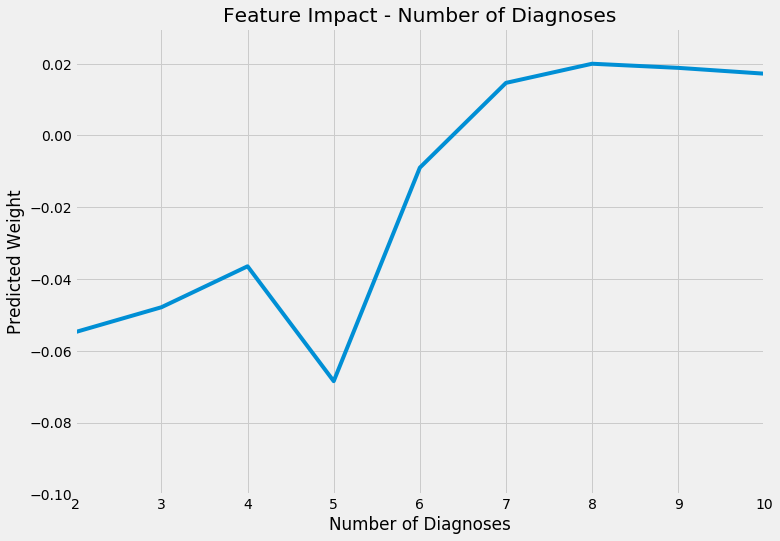

In [80]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(11,8))
ax.plot(list(diagnoses.feature_value),diagnoses.weight)
plt.xlim(2,10)
plt.ylim(-0.1,.03)
plt.xlabel('Number of Diagnoses')
plt.ylabel('Predicted Weight')
plt.title('Feature Impact - {}'.format('Number of Diagnoses'))